# read and process data files

## read from disk

In [151]:
import pandas as pd

ele_props = pd.read_csv('../dataset/PureElements.csv')
vec = pd.read_csv('../dataset/VEC.csv', header=None, names=['elem', 'vec'])

In [152]:
import numpy as np

vec_array = np.zeros(ele_props.shape[0])*np.nan
for i, ele in enumerate(ele_props['elem']):
    ele_vec = vec.loc[vec['elem']==ele, 'vec'].values
    if len(ele_vec) == 1:
        vec_array[i] = ele_vec[0]
    else:
        print(f'Problem with {ele}: ', ele_vec)
ele_props['VEC'] = vec_array

Problem with Tc:  []
Problem with Pm:  []
Problem with Tc:  []
Problem with Pm:  []


In [153]:
uts = pd.read_csv('../dataset/ultimate tensile strength.csv', index_col=0)

In [154]:
from pymatgen import core as pmc

elements = []
for d in uts['Composition']:
    c = pmc.Composition(d).get_el_amt_dict()
    elements += [e for e in c.keys()]
elements = sorted(list(set(elements)))
element_ids = {e: i for i, e in enumerate(elements)}

compositions = np.zeros([len(uts), len(elements)])
for i, d in enumerate(uts['Composition']):
    c = pmc.Composition(d).get_el_amt_dict()
    for c, q in c.items():
        j = element_ids[c]
        compositions[i, j] = q

compositions = compositions / compositions.sum(axis=1).reshape(-1, 1)

for i, ele in enumerate(elements):
    uts[ele] = compositions[:, i]

## perform the interpolations

In [63]:
def select_prop(prop):
    prop_list = np.zeros(len(elements))*np.nan
    for i, ele in enumerate(elements):
        ele_vol = ele_props.loc[ele_props['elem']==ele, prop].values
        if len(ele_vol) >= 1:
            prop_list[i] = ele_vol[0]  # sorted by bcc / fcc / hcp -> we want the top result
    return prop_list


def rule_of_mixtures(compositions, prop):
    ele_prop = select_prop(prop)
    ele_vol = select_prop('DFTv0')
    return np.nansum(ele_prop * ele_vol * compositions, axis=1) / np.nansum(ele_vol * compositions, axis=1)


def property_deviation(compositions, prop):
    ele_prop = select_prop(prop)
    avg_prop = rule_of_mixtures(compositions, prop)
    return np.sqrt(np.nansum(compositions * (1-ele_prop/avg_prop)))

In [201]:
# faster way to compute these...with linear algebra
class VolumeReweighter(object):
    def __init__(self, properties, elements, elemental_data):
        self.properties = properties
        self.elements = elements
        self.data_ = elemental_data

        self.ele_vol_ = self.select_property('DFTv0')
        self.ele_vol_[np.isnan(self.ele_vol_)] = 0  # ignore nan values

        self.local_props_ = np.array([self.select_property(p) for p in self.properties])
        self.local_props_[np.isnan(self.local_props_)] = 0  # ignore nan values

    def select_property(self, property):
        """Retrieve elemental properties in the order specified by elements_"""
        property_list = np.zeros(len(self.elements))*np.nan
        for i, ele in enumerate(self.elements):
            ele_vol = self.data_.loc[self.data_['elem']==ele, property].values
            if len(ele_vol) >= 1:
                property_list[i] = ele_vol[0]  # sorted by bcc / fcc / hcp -> we want the top result
        return property_list

    def transform(self, compositions):
        """Do the rule of mixtures reweighting on specified compositions"""
        weighted_comps = self.ele_vol_*compositions
        numerator = weighted_comps@self.local_props_.T
        normalization = (compositions@self.ele_vol_).reshape(-1, 1)
        return numerator / normalization

In [198]:
ele_vol

array([16.578,  0.   , 10.901, 11.575, 12.025, 11.358, 22.392, 10.789,
       15.956, 18.342, 10.92 , 14.602,  0.   , 18.313, 17.268, 13.453,
       23.242])

In [202]:
rom = VolumeReweighter(all_props, elements, ele_props)
weighted_props = rom.transform(compositions)
idx = [i for i, p in enumerate(all_props) if p == 'Radius_vDW']
weighted_props[:, idx]

array([[183.94311561],
       [188.82177147],
       [178.0642683 ],
       [184.74143406],
       [201.59252489],
       [194.44830908],
       [174.10498772],
       [187.16728043],
       [180.99683891],
       [186.33884057],
       [174.10498772],
       [178.56205584],
       [179.42534576],
       [181.66386274],
       [180.99683891],
       [187.05349009],
       [176.11696402],
       [171.66410052],
       [174.10498772],
       [186.27599426],
       [183.14005847],
       [190.24330544],
       [184.65565089],
       [186.27599426],
       [176.54594324],
       [176.54594324],
       [201.59252489],
       [179.1032009 ],
       [184.65565089],
       [184.65565089],
       [186.54105258],
       [176.11696402],
       [176.31946579],
       [188.57485765],
       [194.15608288],
       [194.15608288],
       [177.18733045],
       [201.59252489],
       [180.82805522],
       [187.05349009],
       [186.27599426],
       [176.54594324],
       [184.74143406],
       [184

In [203]:
prop = 'Radius_vDW'
ele_prop = select_prop(prop).reshape(1, -1)
avg_prop = rule_of_mixtures(compositions, prop)
avg_prop

array([183.94311561, 188.82177147, 178.0642683 , 184.74143406,
       201.59252489, 194.44830908, 174.10498772, 187.16728043,
       180.99683891, 186.33884057, 174.10498772, 178.56205584,
       179.42534576, 181.66386274, 180.99683891, 187.05349009,
       176.11696402, 171.66410052, 174.10498772, 186.27599426,
       183.14005847, 190.24330544, 184.65565089, 186.27599426,
       176.54594324, 176.54594324, 201.59252489, 179.1032009 ,
       184.65565089, 184.65565089, 186.54105258, 176.11696402,
       176.31946579, 188.57485765, 194.15608288, 194.15608288,
       177.18733045, 201.59252489, 180.82805522, 187.05349009,
       186.27599426, 176.54594324, 184.74143406, 184.65565089,
       171.66410052, 180.99683891, 187.05349009, 183.94311561,
       188.82177147, 181.7298569 , 185.56068103, 184.65565089,
       178.0642683 , 201.59252489, 186.27599426, 192.83834024,
       184.65565089, 184.65565089, 184.47842888, 178.89814955,
       184.74143406, 186.74527543, 184.58922304, 184.68

In [66]:
ele_props.columns

Index(['Str1', 'elem', 'PP_radius_s', 'PP_radius_p', 'USFE', 'SurfEne', 'ISIS',
       'Number', 'EleNeg_Miedema', 'EleDensity_Miedema', 'V0_Miedema',
       'Period', 'Group', 'M_Num2', 'Mass', 'Radius_Coval', 'VaporHeat',
       'Ion_Pot_1', 'Ion_Pot_2', 'Ion_Pot_3', 'Radius_vDW', 'EleNeg_Pauling',
       'No_Spectral_lines', 'MaxR_Ele_in_Solid', 'Heat_Capacity', 'BoilingT',
       'MeltingT', 'Heat_Fusion', 'Heat_Sublimation', 'CohEnergy', 'DebyeT',
       'Therm_Conduc', 'Ele_Conduc', 'S298', 'Electron_Affinity', 'Y_wiki',
       'B_wiki', 'G_wiki', 'WorkFunc', 'NsVal', 'NpVal', 'NdVal', 'Nval',
       'NsUnfill', 'NpUnfill', 'NdUnfill', 'NUnfill', 'Va_Activa', 'DFTBh',
       'DFTGh', 'DFTYoung', 'DFTv0', 'NDFTC11', 'NDFTC12', 'NDFTC44',
       'DFTBhvGh', 'DFTGvb', 'DFTGV', 'DFTpoisson', 'ratio_bh', 'Gb2pih',
       'BGsq', 'GGB32', 'PackingEff', 'SpaceGroup', 'NfVal', 'NfUnfill',
       'Va_Form', 'DFTC11', 'DFTC12', 'DFTC44', 'DFTC13', 'DFTC33', 'NDFTCxx',
       'VEC'],
      

In [ ]:
# omega = Tm * deltaSmix / deltaHmix

In [204]:
all_props = ['PP_radius_s', 'PP_radius_p', 'USFE', 'SurfEne', 'ISIS',
             'Number', 'EleNeg_Miedema', 'EleDensity_Miedema', 'V0_Miedema',
             'Period', 'Group', 'M_Num2', 'Mass', 'Radius_Coval', 'VaporHeat',
             'Ion_Pot_1', 'Ion_Pot_2', 'Ion_Pot_3', 'Radius_vDW', 'EleNeg_Pauling',
             'No_Spectral_lines', 'MaxR_Ele_in_Solid', 'Heat_Capacity', 'BoilingT',
             'MeltingT', 'Heat_Fusion', 'Heat_Sublimation', 'CohEnergy', 'DebyeT',
             'Therm_Conduc', 'Ele_Conduc', 'S298', 'Electron_Affinity', 'Y_wiki',
             'B_wiki', 'G_wiki', 'WorkFunc', 'NsVal', 'NpVal', 'NdVal', 'Nval',
             'NsUnfill', 'NpUnfill', 'NdUnfill', 'NUnfill', 'Va_Activa', 'DFTBh',
             'DFTGh', 'DFTYoung', 'DFTv0', 'NDFTC11', 'NDFTC12', 'NDFTC44',
             'DFTBhvGh', 'DFTGvb', 'DFTGV', 'DFTpoisson', 'ratio_bh', 'Gb2pih',
             'BGsq', 'GGB32', 'PackingEff', 'SpaceGroup', 'NfVal', 'NfUnfill',
             'Va_Form', 'DFTC11', 'DFTC12', 'DFTC44', 'DFTC13', 'DFTC33', 'NDFTCxx',
             'VEC']
features_df = pd.DataFrame(np.array([rule_of_mixtures(compositions, p) for p in all_props]).T, columns=all_props)
rom = VolumeReweighter(all_props, elements, ele_props)

In [308]:
all_props = ['USFE', 'SurfEne', 'ISIS', 'Period', 'Group', 'Mass', 'Radius_Coval', 'VaporHeat',
             'Ion_Pot_1', 'Ion_Pot_2', 'Ion_Pot_3', 'Radius_vDW', 'EleNeg_Pauling',
             'Heat_Capacity', 'BoilingT', 'MeltingT', 'Heat_Fusion', 'Heat_Sublimation',
             'Therm_Conduc', 'Ele_Conduc', 'Y_wiki', 'B_wiki', 'G_wiki', 'WorkFunc',
             'DFTBh', 'DFTGh', 'DFTYoung', 'DFTv0', 'VEC']

features_df = pd.DataFrame(np.array([rule_of_mixtures(compositions, p) for p in all_props]).T, columns=all_props)
rom = VolumeReweighter(all_props, elements, ele_props)

In [ ]:
feature_props = ['VEC', 'MeltingT', 'Heat_Capacity', ]

In [64]:
# rule_of_mixtures(compositions, 'VEC')
rule_of_mixtures(compositions, 'Heat_Capacity')

array([8.67316774, 8.1309727 , 7.78403357, 8.33420026, 4.36818104,
       7.50114348, 8.24570965, 7.85299906, 7.69134718, 8.06120588,
       8.24570965, 7.99616443, 8.14816339, 7.1085992 , 7.69134718,
       7.97843113, 8.42310339, 9.52234316, 8.24570965, 8.06692224,
       8.98679888, 7.22763224, 8.21430487, 8.06692224, 9.03632597,
       9.03632597, 4.36818104, 8.33418554, 8.21430487, 8.21430487,
       8.4992722 , 8.42310339, 8.0648706 , 8.21516852, 7.60033323,
       7.60033323, 7.49256376, 4.36818104, 7.34790905, 7.97843113,
       8.06692224, 9.03632597, 8.33420026, 8.21430487, 9.52234316,
       7.69134718, 7.97843113, 8.67316774, 8.1309727 , 7.88665082,
       8.08411344, 8.21430487, 7.78403357, 4.36818104, 8.06692224,
       4.31166316, 8.21430487, 8.21430487, 6.80488163, 7.14638761,
       8.33420026, 8.01284049, 7.68601295, 7.79614348, 7.84538508,
       8.1309727 , 7.69280517, 7.74996203, 4.47502106, 7.69134718,
       8.76664795, 7.60033323, 8.01284049, 8.42768858, 8.06692

# perform regression

In [328]:
from sklearn import ensemble, model_selection

x = rom.transform(compositions)
y = uts['ultimate tensile strength']

splits = model_selection.train_test_split(x, y, test_size=0.2, random_state=0)
xtrain, xtest, ytrain, ytest = splits

model = ensemble.RandomForestRegressor().fit(xtrain, ytrain)
model.score(xtest, ytest)

0.09129931989963214

# recover the compositions

In [309]:
from sklearn import preprocessing

scaler = preprocessing.StandardScaler()
scaled_features_df = scaler.fit_transform(features_df.values)

In [229]:
import pygad


target = scaled_features_df[0]

def fitness_fn(solution, solution_idx):
    if len(np.array(solution).shape) == 1:
        solution = [solution]
    norm_chem = solution / np.sum(solution)
    y_pred = rom.transform(solution)
    # y_pred = np.array([rule_of_mixtures(norm_chem, p) for p in all_props]).T
    y_hat = scaler.transform(y_pred)
    prop_target = -np.linalg.norm(y_hat - target)
    # sum_target = -(np.sum(solution) - 1)**2  # soft constraint
    # print(solution, prop_target, sum_target)
    return prop_target # + sum_target


ga_instance = pygad.GA(num_generations=512,
                    num_parents_mating=8,
                    fitness_func=fitness_fn,
                    sol_per_pop=32,
                    num_genes=len(elements),
                    init_range_low=0,
                    init_range_high=1,
                    random_mutation_min_val=0,
                    random_mutation_max_val=1,
                    parent_selection_type="sss",
                    keep_parents=-1,
                    crossover_type="two_points",
                    mutation_type="random",
                    mutation_percent_genes=10,
                    save_solutions=True,
                    )

ga_instance.run()

/Users/wfr5091/opt/anaconda3/envs/forward_v_inverse/lib/python3.10/site-packages/pygad/pygad.py:828: UserWarning: Use the 'save_solutions' parameter with caution as it may cause memory overflow when either the number of generations, number of genes, or number of solutions in population is large.
  if not self.suppress_warnings: warnings.warn("Use the 'save_solutions' parameter with caution as it may cause memory overflow when either the number of generations, number of genes, or number of solutions in population is large.")


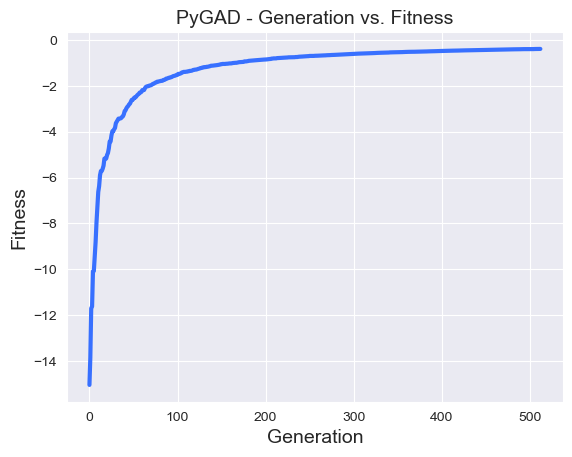

In [230]:
_ = ga_instance.plot_fitness()

In [231]:
top_k = 5

u, u_idx = np.unique(ga_instance.solutions, axis=0, return_index=True)
u_fit = np.array([ga_instance.solutions_fitness[i] for i in u_idx])
top_idx = np.argsort(u_fit)[::-1][:top_k]
x_ga = np.array([u[i] for i in top_idx])
x_ga /= x_ga.sum(axis=1).reshape(-1, 1)

print(u_fit[top_idx].round(3))
x_ga

[-0.39  -0.39  -0.391 -0.392 -0.392]


array([[8.74791526e-04, 8.57335562e-02, 2.71805861e-01, 1.79861523e-03,
        2.25545806e-03, 3.63725007e-03, 3.44622100e-04, 2.69396058e-01,
        2.71501610e-03, 1.13001497e-04, 2.71523257e-01, 4.06458521e-04,
        8.64331886e-02, 7.40756086e-04, 1.78021511e-03, 2.77965170e-04,
        1.63929753e-04],
       [8.74443730e-04, 8.56994706e-02, 2.69615892e-01, 1.79790014e-03,
        2.25456135e-03, 3.63580398e-03, 3.44485087e-04, 2.69288952e-01,
        2.71393667e-03, 1.12956571e-04, 2.73894788e-01, 4.06296923e-04,
        8.63988249e-02, 7.40461579e-04, 1.77950734e-03, 2.77854658e-04,
        1.63864578e-04],
       [8.76804171e-04, 8.51752227e-02, 2.71508540e-01, 1.80275333e-03,
        2.26064723e-03, 3.64561834e-03, 3.45414977e-04, 2.69393398e-01,
        2.72126257e-03, 1.13261482e-04, 2.72147954e-01, 4.07393666e-04,
        8.66320467e-02, 7.42460354e-04, 1.78431088e-03, 2.78604689e-04,
        1.64306908e-04],
       [8.75711978e-04, 8.50691240e-02, 2.70006929e-01, 1.800

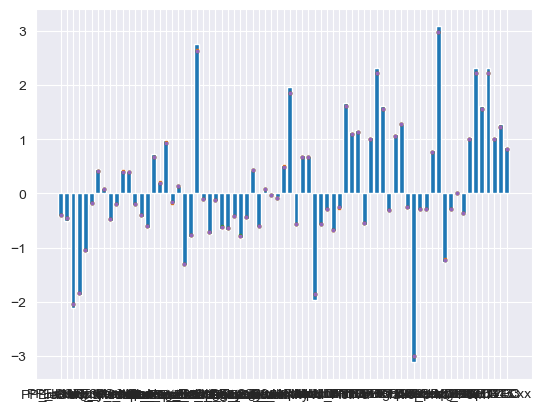

In [232]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots()
ax.bar(features_df.columns, target)

y_pred = np.array([rule_of_mixtures(x_ga, p) for p in all_props]).T
y_hat = scaler.transform(y_pred)
ax.plot(y_hat.T, 's', ms=2)

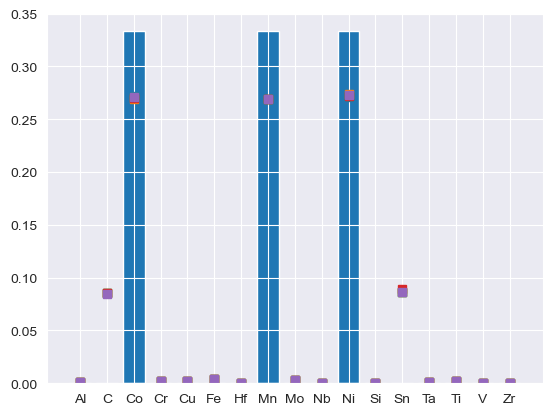

In [233]:
fig, ax = plt.subplots()
ax.bar(elements, compositions[0], zorder=0)
ax.plot(x_ga.T, 's', zorder=1)

# bayesian optimization

In [311]:
t_idx = 4
target = scaled_features_df[t_idx]
print({ele: compositions[t_idx][i] for i, ele in enumerate(elements)})

{'Al': 0.0, 'C': 0.0, 'Co': 0.0, 'Cr': 0.0, 'Cu': 0.0, 'Fe': 0.0, 'Hf': 0.2, 'Mn': 0.0, 'Mo': 0.0, 'Nb': 0.2, 'Ni': 0.0, 'Si': 0.0, 'Sn': 0.0, 'Ta': 0.2, 'Ti': 0.2, 'V': 0.0, 'Zr': 0.2}


In [312]:
from bayes_opt import BayesianOptimization, SequentialDomainReductionTransformer


def bo_fitness_fn(**solution_dict):
    solution = np.array([solution_dict[ele] for ele in elements])
    if len(np.array(solution).shape) == 1:
        solution = [solution]
    norm_chem = solution / np.sum(solution)
    y_pred = rom.transform(norm_chem)
    y_hat = scaler.transform(y_pred)
    prop_target = -np.linalg.norm(y_hat - target)
    return prop_target

# Bounded region of parameter space
pbounds = {ele: (0, 1) for ele in elements}
# bounds_transformer = SequentialDomainReductionTransformer(minimum_window=0.5)

optimizer = BayesianOptimization(
    f=bo_fitness_fn,
    pbounds=pbounds,
    random_state=0,
    # bounds_transformer=bounds_transformer,
)

optimizer.maximize(
    init_points=50, n_iter=50,
    # acq="ei", xi=0,
    # acq="ucb", kappa=10,# kappa_decay=1-1e-3,
)

|   iter    |  target   |    Al     |     C     |    Co     |    Cr     |    Cu     |    Fe     |    Hf     |    Mn     |    Mo     |    Nb     |    Ni     |    Si     |    Sn     |    Ta     |    Ti     |     V     |    Zr     |
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
| 1         | -10.48    | 0.5488    | 0.7152    | 0.6028    | 0.5449    | 0.4237    | 0.6459    | 0.4376    | 0.8918    | 0.9637    | 0.3834    | 0.7917    | 0.5289    | 0.568     | 0.9256    | 0.07104   | 0.08713   | 0.02022   |
| 2         | -9.659    | 0.8326    | 0.7782    | 0.87      | 0.9786    | 0.7992    | 0.4615    | 0.7805    | 0.1183    | 0.6399    | 0.1434    | 0.9447    | 0.5218    | 0.4147    | 0.2646    | 0.7742    | 0.4562    | 0.5684    |
| 3         | -11.02    | 0.01879   | 0.6176    | 0.6121    | 0.6169    | 0.9437

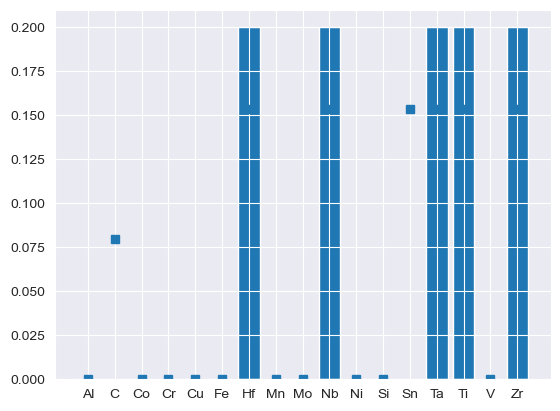

In [313]:
x_bo = np.array([optimizer.max['params'][ele] for ele in elements])
x_bo /= np.sum(x_bo)

fig, ax = plt.subplots()
ax.bar(elements, compositions[t_idx], zorder=0)
ax.plot(x_bo, 's', zorder=1)

# torch

In [277]:
import torch

In [314]:
from doepy import build

design = build.space_filling_lhs(
    {ele: (0, 1) for ele in elements},
    num_samples = 150
)

optimizer = BayesianOptimization(
    f=bo_fitness_fn,
    pbounds=pbounds,
    random_state=0,
    # bounds_transformer=bounds_transformer,
)

for d in design.values:
    optimizer.probe(params=d, lazy=True)

optimizer.maximize(
    init_points=0, n_iter=50,
    # acq="ei", xi=0,
    acq="ucb", kappa=10, kappa_decay=1-1e-2,
)

|   iter    |  target   |    Al     |     C     |    Co     |    Cr     |    Cu     |    Fe     |    Hf     |    Mn     |    Mo     |    Nb     |    Ni     |    Si     |    Sn     |    Ta     |    Ti     |     V     |    Zr     |
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
| 1         | -9.075    | 0.7047    | 0.6913    | 0.1208    | 0.604     | 0.1812    | 0.2483    | 0.3423    | 0.2819    | 0.3893    | 0.7315    | 0.2483    | 0.9866    | 0.9195    | 0.1879    | 0.906     | 0.4228    | 0.6443    |
| 2         | -8.431    | 0.2013    | 0.01342   | 0.6779    | 0.3087    | 0.6779    | 0.7919    | 0.5369    | 0.4698    | 0.8188    | 0.1342    | 0.7785    | 0.1074    | 0.4765    | 0.8523    | 0.302     | 0.3289    | 0.5638    |
| 3         | -7.967    | 0.443     | 0.7651    | 0.2752    | 0.5369    | 0.4027

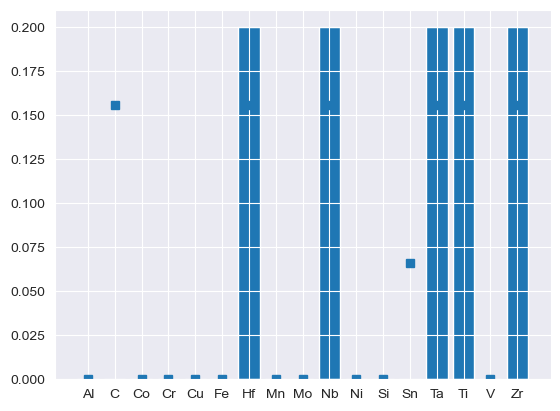

In [315]:
x_bo = np.array([optimizer.max['params'][ele] for ele in elements])
x_bo /= np.sum(x_bo)

fig, ax = plt.subplots()
ax.bar(elements, compositions[t_idx], zorder=0)
ax.plot(x_bo, 's', zorder=1)

In [321]:
design = build.space_filling_lhs(
    {ele: (0, 1) for ele in elements},
    num_samples = 150
)
scaler.inverse_transform(rom.transform(design.values))

array([[6.77439618e-01, 2.82749057e+00, 2.14210460e+01, ...,
        5.73161193e+03, 5.23913002e+01, 1.44985734e+01],
       [6.39324806e-01, 2.69989081e+00, 1.77807774e+01, ...,
        4.78789129e+03, 5.31017555e+01, 1.45049746e+01],
       [6.34805714e-01, 2.70308422e+00, 1.63425018e+01, ...,
        4.95691953e+03, 5.65108920e+01, 1.42101313e+01],
       ...,
       [6.35019141e-01, 2.72335605e+00, 1.74086437e+01, ...,
        4.66708649e+03, 5.74994891e+01, 1.44196779e+01],
       [6.48150929e-01, 2.73628539e+00, 1.84444568e+01, ...,
        5.08177279e+03, 5.24195398e+01, 1.46331081e+01],
       [6.43121353e-01, 2.67474435e+00, 1.78907011e+01, ...,
        4.84762100e+03, 5.57556130e+01, 1.38759750e+01]])